In [1]:
import numpy as np
import pandas as pd
# This library is to visualise statistical graphs
import seaborn as sns

# This library is to visualise graphs
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df_trans = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
df_identity = pd.read_csv('ieee-fraud-detection/train_identity.csv')
train = pd.merge(df_trans, df_identity, how='left', 
                 on='TransactionID', left_index=True, 
                right_index=True)

In [3]:
df_test_trans = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
df_test_identity = pd.read_csv('ieee-fraud-detection/test_identity.csv')
test = pd.merge(df_test_trans, df_test_identity, how='left', on='TransactionID',
                left_index=True, right_index=True)

In [4]:
test = test.rename(columns={"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [5]:
target = train['isFraud']

In [6]:
def getnulls(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'precent'])
    return missing_data

In [7]:
missing_data = getnulls(train)
droppedcols = missing_data[missing_data['total'] > 100000].index
train.drop(droppedcols, axis=1, inplace=True)

In [8]:
test.drop(droppedcols, axis=1, inplace=True)

Add some new features from the email domain

In [9]:
train['emails'] = train['P_emaildomain'].str.split('.',expand=True)[0]

In [10]:
train['emails'].isnull().value_counts()

False    496084
True      94456
Name: emails, dtype: int64

In [11]:
train['emails'].fillna('unkown', inplace=True)
train['E_Domain'] = train['P_emaildomain'].str.split('.',expand=True)[1]

In [12]:
train['E_Domain'].isnull().value_counts()

False    495588
True      94952
Name: E_Domain, dtype: int64

In [13]:
train['E_Domain'].fillna('unkown', inplace=True)

The R_emaidomain has been dropped so we do not worry about the column

train['R_emails'] = train['R_emaildomain'].str.split('.',expand=True)[0]
train['R_emails'].isnull().value_counts()
train['R_emails'].fillna('unkown', inplace=True)
train['R_E_Domain'] = train['R_emaildomain'].str.split('.',expand=True)[1]
train['R_E_Domain'].isnull().value_counts()
train['R_E_Domain'].fillna('unkown', inplace=True)

Add the same columns to the test data

In [14]:
test['emails'] = test['P_emaildomain'].str.split('.',expand=True)[0]
test['emails'].isnull().value_counts()
test['emails'].fillna('unkown', inplace=True)
test['E_Domain'] = test['P_emaildomain'].str.split('.',expand=True)[1]
test['E_Domain'].isnull().value_counts()
test['E_Domain'].fillna('unkown', inplace=True)

From the analysis before, we know that there is no strong relation between a feature and target so we need to keep as many features as possible.

We will add all the data together to fill na values for better prediction on the set. 

In [15]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis=0, sort=False)
all_data.shape

(1097231, 184)

### Fill na values

Fill all the categorical data 

#### Categorical Features - Transaction

ProductCD
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9

#### Categorical Features - Identity

DeviceType
DeviceInfo
id_12 - id_38


In [16]:
all_data_cols = all_data.columns
for i in all_data_cols:
    if all_data[i].dtype == 'object':
        print("Filling {} with the most frequent value ".format(i))
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

Filling ProductCD with the most frequent value 
Filling card4 with the most frequent value 
Filling card6 with the most frequent value 
Filling P_emaildomain with the most frequent value 
Filling emails with the most frequent value 
Filling E_Domain with the most frequent value 


In [17]:
cols = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']
for i in cols:
    all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [18]:
for i in all_data_cols:
    if (i.startswith("id") or (i.startswith("D")) or (i.startswith("V")) ) and all_data[i].isnull().sum() > 0:
        all_data[i] = all_data[i].fillna(all_data[i].mode()[0])

In [19]:
print(ntrain)
print(ntest)
print(ntrain+ntest)
print(all_data.shape)

590540
506691
1097231
(1097231, 184)


In [20]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

# Encoding all the features for the first model 

In [ ]:
all_encoded = all_data.copy()

In [ ]:
all_encoded.drop(columns=['P_emaildomain'], inplace=True)

In [ ]:
features_to_encode = ['ProductCD', 'addr1', 'addr2',
                      'emails', 'E_Domain']
# features_to_encode = ['addr1', 'addr2',
#                       'emails', 'E_Domain']

for feature in features_to_encode:
    all_encoded = encode_and_bind(all_encoded, feature)
    
for i in all_data_cols:
    if (i.startswith("id") or (i.startswith("c")) or (i.startswith("M")) ):
        all_encoded = encode_and_bind(all_encoded, i)

In [ ]:
train = all_encoded[:ntrain]
test = all_encoded[ntrain:]
train.drop(['TransactionID'], axis=1, inplace=True)
test_id = test['TransactionID']
test.drop(['TransactionID'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

In [ ]:
train.drop(['isFraud'], axis=1, inplace=True)
test.drop(['isFraud'], axis=1, inplace=True)

In [ ]:
# XGBOOST
xgmodel = xgb.XGBClassifier(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=50, 
                             min_child_weight=1.7817, n_estimators=200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
xgmodel.fit(train, target)

In [ ]:
y_pred_xg = xgmodel.predict_proba(test)

In [ ]:
y_pred_xg.shape

In [ ]:
sub = pd.DataFrame()
sub['TransactionID'] = test_id
sub['isFraud'] = y_pred_xg[:, 1]
sub.to_csv('submission_xgb.csv', index=False)

This gives me a score of 0.918666 on Kaggle submission. 

# Encoding the features pandas thinks is needed

In [26]:
all_data_encode = pd.get_dummies(all_data)
print(all_data_encode.shape)

(1097231, 306)


In [27]:
train = all_data_encode[:ntrain]
test = all_data_encode[ntrain:]
train.drop(['TransactionID'], axis=1, inplace=True)
test_id = test['TransactionID']
test.drop(['TransactionID'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(590540, 305)
(506691, 305)


In [28]:
train.drop(['isFraud'], axis=1, inplace=True)
test.drop(['isFraud'], axis=1, inplace=True)

In [37]:
# XGBOOST
xgmodel = xgb.XGBClassifier(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=50, 
                             min_child_weight=1.7817, n_estimators=200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1, verbosity=1)
xgmodel.fit(train, target)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:53:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=50,
              min_child_weight=1.7817, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, nthread=-1, num_parallel_tree=1,
              random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
              scale_pos_weight=1, subsample=0.5213, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [46]:
y_pred_xg = xgmodel.predict_proba(test)

In [71]:
(y_pred_xg[0])

array([0.99760187, 0.00239812], dtype=float32)

In [48]:
y_pred_xg.shape

(506691, 2)

In [49]:
sub = pd.DataFrame()
sub['TransactionID'] = test_id
sub['isFraud'] = y_pred_xg[:, 1]
sub.to_csv('submission_xgb2.csv', index=False)

Score of 0.932687

In [73]:
import joblib 
joblib.dump(xgmodel, 'xgb.pkl')

['xgb.pkl']

Neural NET

In [53]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(225, input_dim=304, activation='relu'))
#     model.add(Dense(150, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [54]:
def train_NN(x_train, y_train, ep, bs):
    model = baseline_model()
    X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2)
#     weights = {0:1, 1:1000}
    history = model.fit(X_train, Y_train, epochs=ep, validation_data=(X_test, Y_test), batch_size=bs)
#     history = model.fit(X_train, Y_train, epochs=5, validation_split=0.33, batch_size=10)
    
#     model.save('modelNN.h5')
    
    return history, model

In [56]:
hist, m = train_NN(train, target, 3, 1)

Epoch 1/3
472432/472432 [==============================] - 1434s 3ms/step - loss: 17.1094 - accuracy: 0.9646 - val_loss: 0.1500 - val_accuracy: 0.9655
Epoch 2/3
472432/472432 [==============================] - 1423s 3ms/step - loss: 0.1556 - accuracy: 0.9649 - val_loss: 0.1503 - val_accuracy: 0.9655
Epoch 3/3
472432/472432 [==============================] - 1397s 3ms/step - loss: 0.1521 - accuracy: 0.9649 - val_loss: 0.1505 - val_accuracy: 0.9655


In [57]:
m.save('temp.h5')

In [58]:
def plot_history(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
#     plt.savefig(name, bbox_inches='tight')
    plt.show()

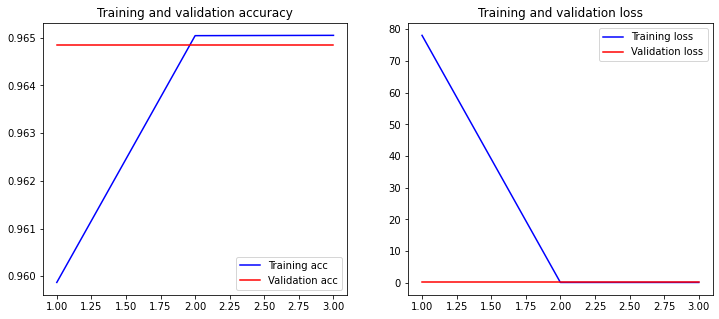

In [30]:
plot_history(hist, 'FirstNN')

score 0.75321

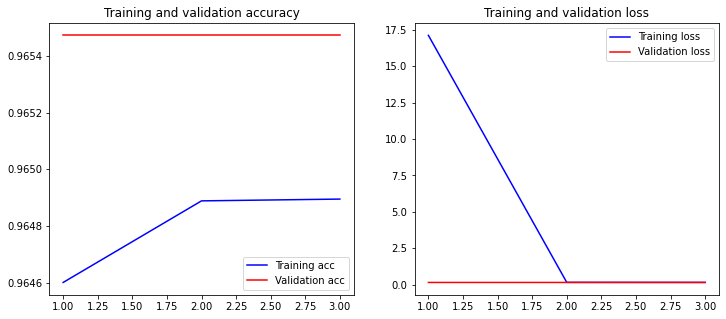

In [59]:
plot_history(hist, 'NNW100')

score 0.87312

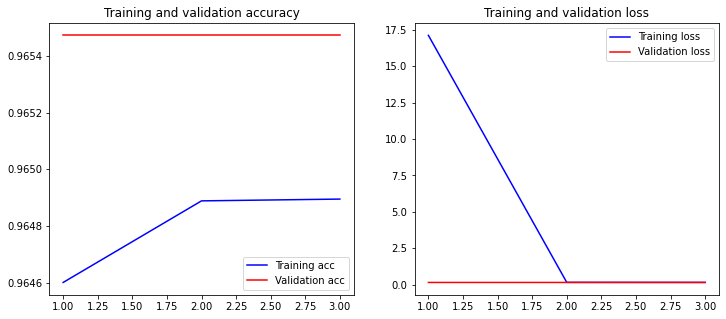

In [60]:
plot_history(hist, 'NNW10K')

Score 0.85134

In [61]:
a = m.predict(test)

In [62]:
a.shape

(506691, 1)

In [ ]:
(np.where(np.isnan(a)))

In [67]:
sub = pd.DataFrame()
sub['TransactionID'] = test_id
sub['isFraud'] = a
sub.to_csv('submission_N1.csv', index=False)

# Unsupervised Learning

In [39]:
def plot_confusion_mat(cm, classes, name):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp = disp.plot(include_values=True,
                     cmap='Blues', ax=None, xticks_rotation='vertical')
#     plt.savefig(name, bbox_inches="tight")
    plt.show()

In [29]:
from sklearn.cluster import KMeans

#standardize the data to normal distribution
from sklearn import preprocessing

In [30]:
train

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,emails_ymail,E_Domain_co,E_Domain_com,E_Domain_de,E_Domain_edu,E_Domain_es,E_Domain_fr,E_Domain_net,E_Domain_rr,E_Domain_unkown
0,86400,68.50,13926,321.0,150.0,142.0,315.0,87.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,86401,29.00,2755,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
2,86469,59.00,4663,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
3,86499,50.00,18132,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,0,0,1,0,0,0,0,0,0,0
4,86506,50.00,4497,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,15811047,49.00,6550,321.0,150.0,226.0,272.0,87.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,1
590536,15811049,39.50,10444,225.0,150.0,224.0,204.0,87.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
590537,15811079,30.95,12037,595.0,150.0,224.0,231.0,87.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
590538,15811088,117.00,7826,481.0,150.0,224.0,387.0,87.0,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0


In [35]:
a = preprocessing.scale(train)
a_train = pd.DataFrame(a)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(a_train, target, test_size=0.2)

In [37]:
#KMeans
km = KMeans(n_clusters=2)
km.fit(X_train)

KMeans(n_clusters=2)

In [38]:
print(classification_report(Y_test, km.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.11      0.19    114005
           1       0.02      0.63      0.05      4103

    accuracy                           0.13    118108
   macro avg       0.46      0.37      0.12    118108
weighted avg       0.86      0.13      0.19    118108



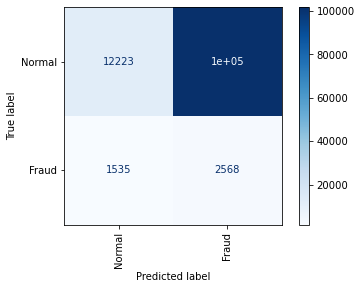

In [43]:
plot_confusion_mat(confusion_matrix(Y_test, km.predict(X_test)), ['Normal', 'Fraud'], 'temp')

In [44]:
from sklearn.mixture import GaussianMixture

In [45]:
#Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)
proba_lists = gmm.predict_proba(X_test)

In [50]:
preds = gmm.predict(X_test)

In [52]:
Y_test

329809    0
307303    0
529987    0
479858    0
99365     0
         ..
446141    1
262487    0
356481    0
465716    0
334799    0
Name: isFraud, Length: 118108, dtype: int64

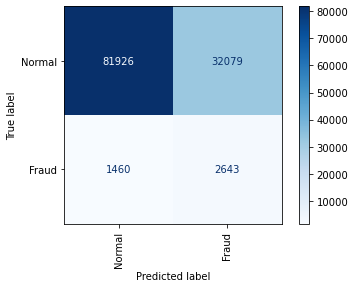

In [53]:
plot_confusion_mat(confusion_matrix(Y_test, preds), ['Normal', 'Fraud'], 'temp')

This give better results than Kmeans with far less False Positives

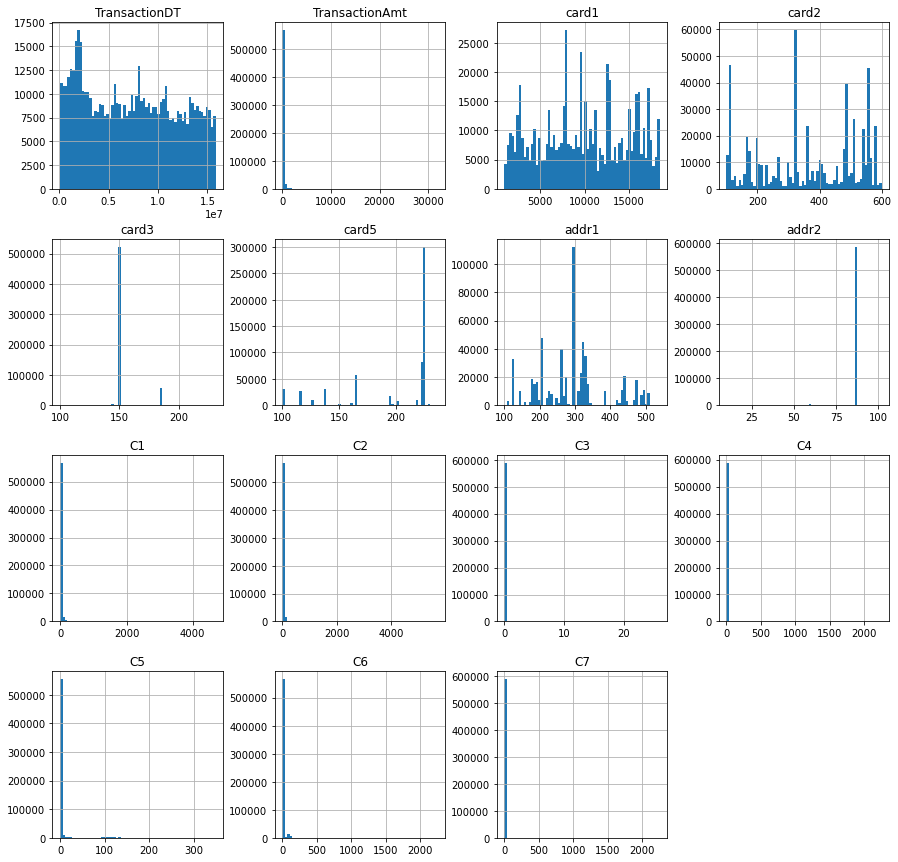

In [61]:
train.iloc[:,:15].hist(figsize=(15,15), bins = 64)
plt.show()

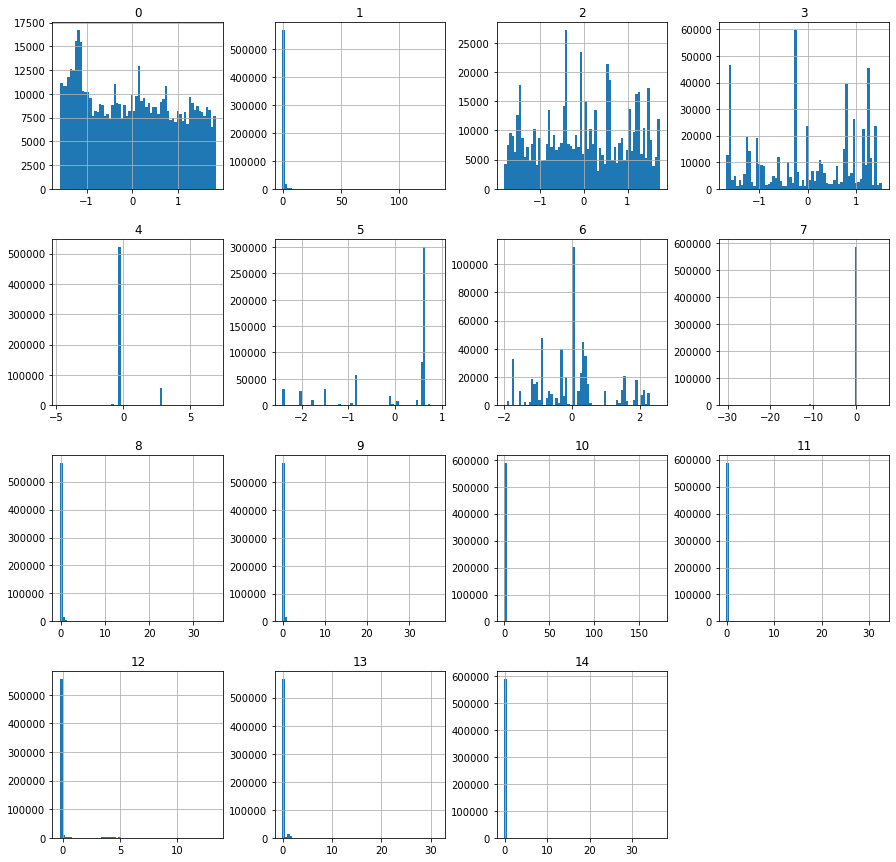

In [63]:
a_train.iloc[:,:15].hist(figsize=(15,15), bins = 64)
plt.show()

In [65]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

In [76]:
a = PowerTransformer().fit_transform(X=train)
a_train = pd.DataFrame(a)

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/opt/conda/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [77]:
a_train.shape

(590540, 304)

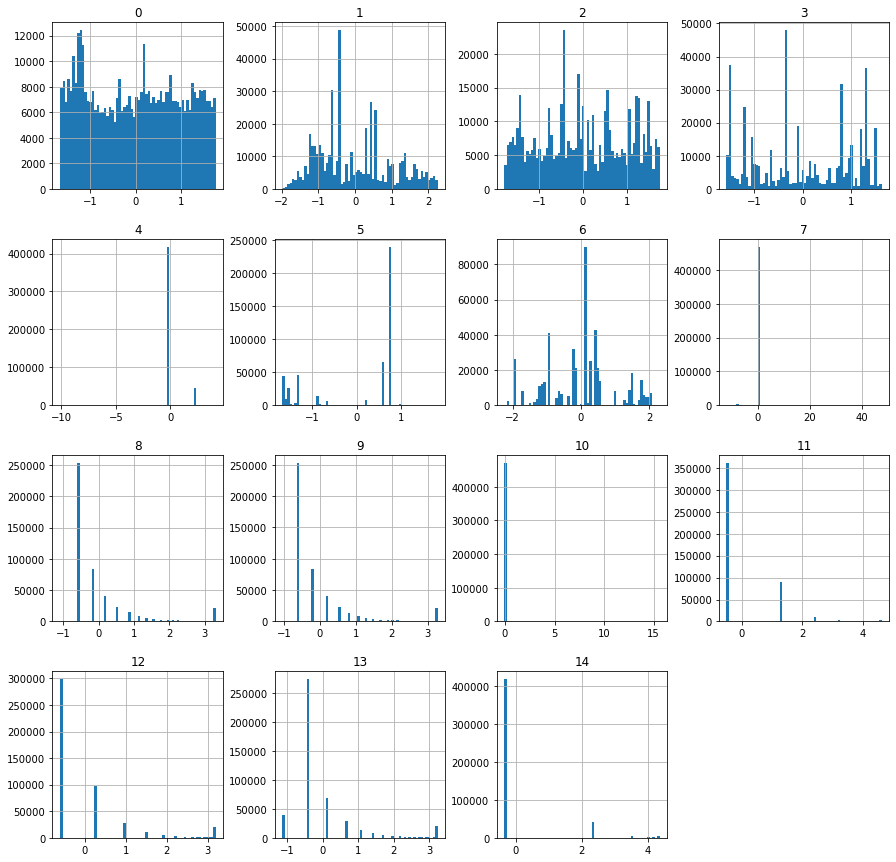

In [72]:
a_train.iloc[:,:15].hist(figsize=(15,15), bins = 64)
plt.show()

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(a_train, target, test_size=0.2)

In [79]:
#Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)
gmm.fit(X_train)

GaussianMixture(n_components=2)

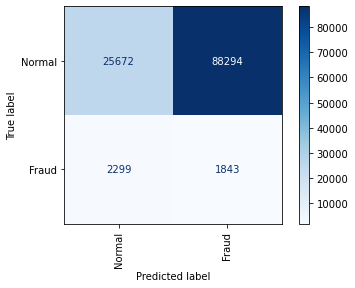

In [80]:
preds = gmm.predict(X_test)
plot_confusion_mat(confusion_matrix(Y_test, preds), ['Normal', 'Fraud'], 'temp')

The best results came from the XGBOOST model 